In [1]:
from param import Param
from sde import *
from fparam import *
import numpy as np
import math
from matplotlib import pyplot as plt

In [10]:
# First we calibrate using the heston model
params = {
    "h_0"  : Param(.11/math.sqrt(21)),
    "theta": Param(.17/math.sqrt(252)),
    "rho"  : Param(-0.674830),
    "kappa": Param(.2),
    "xi"   : Param(1.2),
    "dt"   : Param(1/252),
    "r"    : Param(0.0411/252),
    "S_0"  : Param(100)
}

# Model functions
def feller(params):
    k     = params["kappa"].eval()
    theta = params["theta"].eval()
    xi    = params["xi"].eval()
    return 2 * k * theta > xi * xi

def mu_h(h_t, t, params=None):
    k = params["kappa"].eval()
    theta = params["theta"].eval()
    return k * (theta - h_t)

def v_h(h_t, t, params=None):
    xi = params["xi"].eval()
    return xi * math.sqrt(max(h_t, 0.))

def mu(S_t, t, params=None):
    r = params["r"].eval()
    return r * S_t

def v(S_t, t, cir, params=None):
    vol = cir.nodes[t-1].eval()
    return math.sqrt(max(vol, 0.)) * S_t

drift_h  = FParam(mu_h, params)
vol_h    = FParam(v_h, params)
T   = 252
N   = 1000

cir_sim = EulerSimulation(drift_h, vol_h, params["h_0"], T, params["dt"], N)

drift_s = FParam(mu, params)
vol_s   = FParam(v, params)

simulation = StochVolSimulation(drift_s, vol_s, params["S_0"], cir_sim, T, params["dt"], N, rho=params["rho"].eval())

In [11]:
targets = {
    1: {95: 6.5757, 100: 2.8223, 105: 0.6335},
    2: {95: 8.1165, 100: 4.3850, 105: 1.7263},
    3: {100: 6.0865, 105: 3.1820, 110: 1.2347},
    4: {100: 7.7710, 105: 4.7369, 110: 2.4165}
}

def plot_sims(cir_sim, simulation):
    for i in range(N):
        plt.plot(cir_sim.results[:, i])
    plt.xlabel("Timesteps (252 total)")
    plt.ylabel("Daily Volatility")
    plt.title("Volatility Simulation")
    plt.show()

    for i in range(N):
        plt.plot(simulation.results[:, i])
    plt.xlabel("Timesteps (252 total)")
    plt.ylabel("Index Price")
    plt.title("Index Price Simulation")
    plt.show()
    
def call_price(result, targets, r):
    qt = T // 4
    out = dict()
    sse = 0.
    for m in targets:
        out[m] = dict()
        for strike in targets[m]:
            out[m][strike] = np.maximum((result[(qt*m), :] - strike), 0).mean() * np.exp(- r * qt * m)
            sse += (out[m][strike] - targets[m][strike])**2
    return out, sse

def run_sims(cir_sim, simulation):
    cir_sim.run_all()
    simulation.run_all()

In [32]:
# Calibration
step = 10
theta_grid = [.03] # np.linspace(0.025, 0.032, step)
kappa_grid = [1.2] # np.linspace(0.01, 0.015, step)
xi_grid    = [0.00846] # np.linspace(0.0001, 0.0005, step)
opt_comb   = None
opt_sse    = -1.
opt_out    = None
ct = 0

for theta in theta_grid:
    for kappa in kappa_grid:
        ct += 1
        for xi in xi_grid:
            params["theta"].val = theta
            params["kappa"].val = kappa
            params["xi"].val    = xi
            if feller(params):
                run_sims(cir_sim, simulation)
                out, sse = call_price(simulation.results, targets, params["r"].eval())
                if opt_sse < 0. or sse < opt_sse:
                    opt_sse = sse
                    opt_comb = (theta, kappa, xi)
                    opt_out = out
    if ct % step == 0:
        print(f"Calibration {ct // step}/{step} complete.")

In [33]:
print("SSE: = ", sse)
print("Optimal Combination = ", opt_comb)
print("Call Prices = ", opt_out)

SSE: =  5.3827138688359675
Optimal Combination =  (0.03, 1.2, 0.00846)
Call Prices =  {1: {95: 6.195784403951688, 100: 3.1150832902989043, 105: 1.2835275075216122}, 2: {95: 7.532309781938611, 100: 4.6791849045384195, 105: 2.6733134145069406}, 3: {100: 5.666407236253974, 105: 3.5883659803943346, 110: 2.1238654197708082}, 4: {100: 6.397517413927816, 105: 4.372612812902442, 110: 2.920560377427563}}


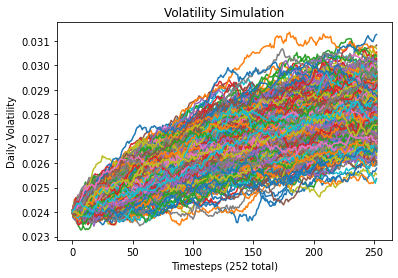

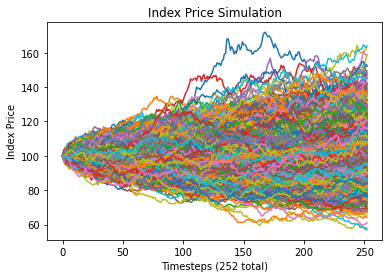

In [34]:
plot_sims(cir_sim, simulation)

In [35]:
simulation.results

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [101.03770172,  99.88415148,  99.6448985 , ..., 101.58396366,
         99.67816037,  99.32567481],
       [100.01104295, 100.65656225,  98.92075494, ..., 101.63727272,
        100.53211587, 100.06181606],
       ...,
       [ 82.95555846,  98.77866542,  98.19830667, ...,  98.63022048,
        108.25483068, 112.85855323],
       [ 81.68819159, 100.2827052 ,  99.39928779, ...,  99.24762988,
        108.27121951, 112.82632817],
       [ 82.27869331,  99.99731864,  98.50135144, ...,  99.29701957,
        108.0073724 , 113.53085274]])

In [36]:
simulation.results[simulation.results < 0]

array([], dtype=float64)